Normalization stats:
Mean: tensor([-5699.4873,  8023.7510])
Std: tensor([601.8121, 847.6780])
History range before norm: -5771.21 to 8124.70
History range after norm: -0.12 to 0.12


C:\Users\FarisHussain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Epoch 50/200
epoch loss: 0.00533056166023016
Average loss: 0.005331

Prediction Statistics:
Average prediction error: 31.97 meters
Final position error: 51.49 meters
Trajectory length - History: 11 steps, Future: 80 steps


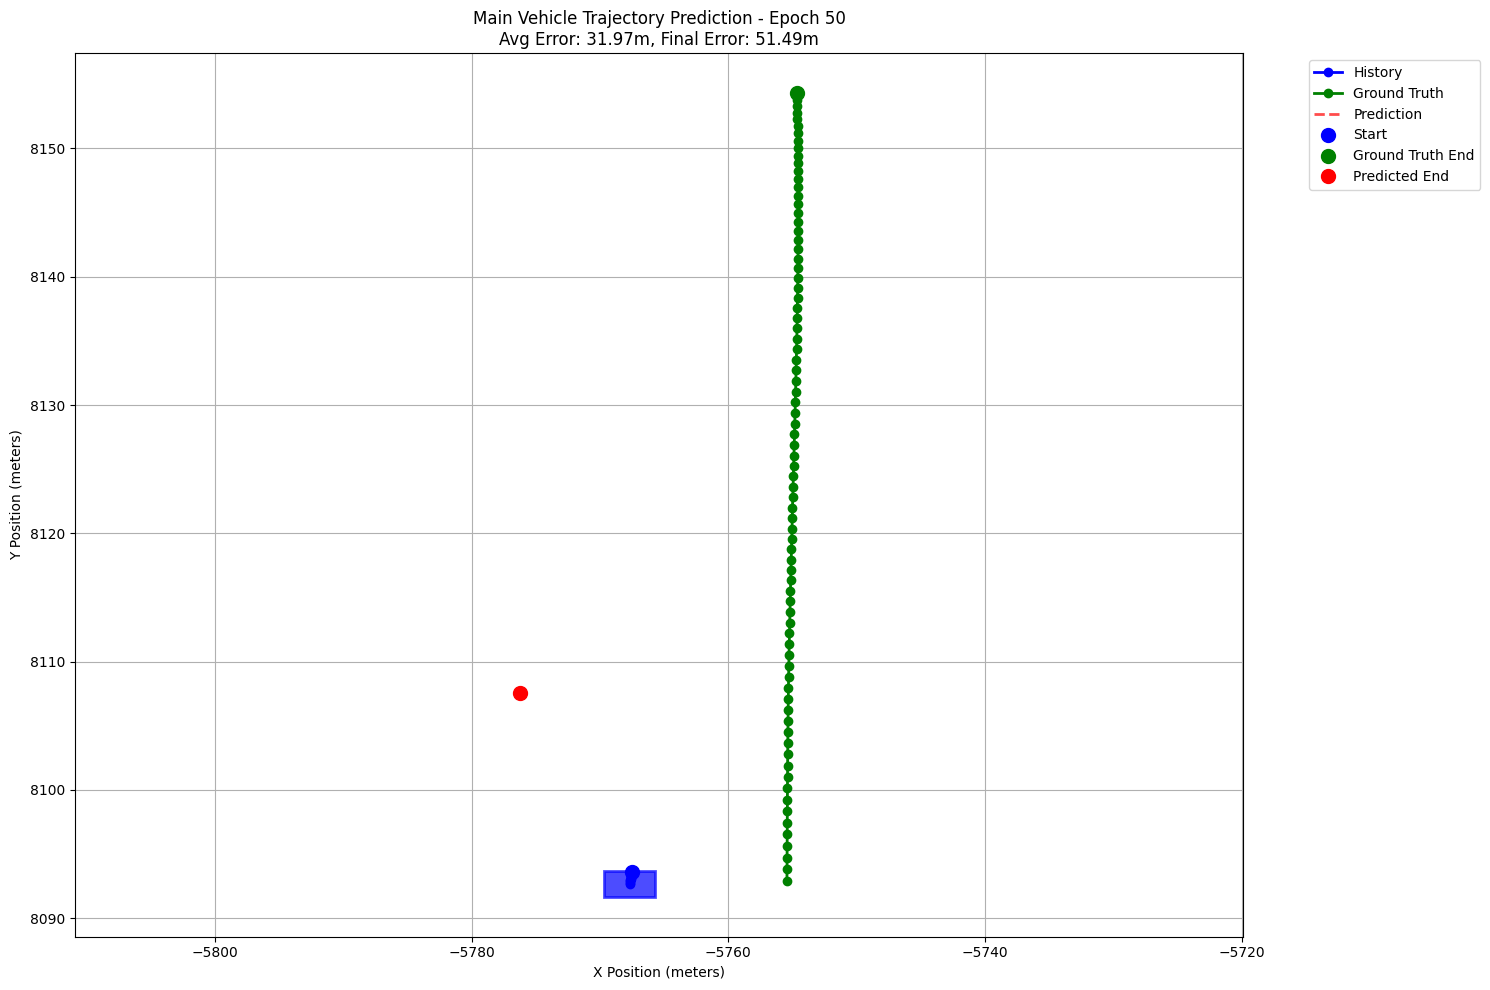


Epoch 100/200
epoch loss: 0.0025597577914595604
Average loss: 0.002560

Prediction Statistics:
Average prediction error: 14.06 meters
Final position error: 28.06 meters
Trajectory length - History: 11 steps, Future: 80 steps


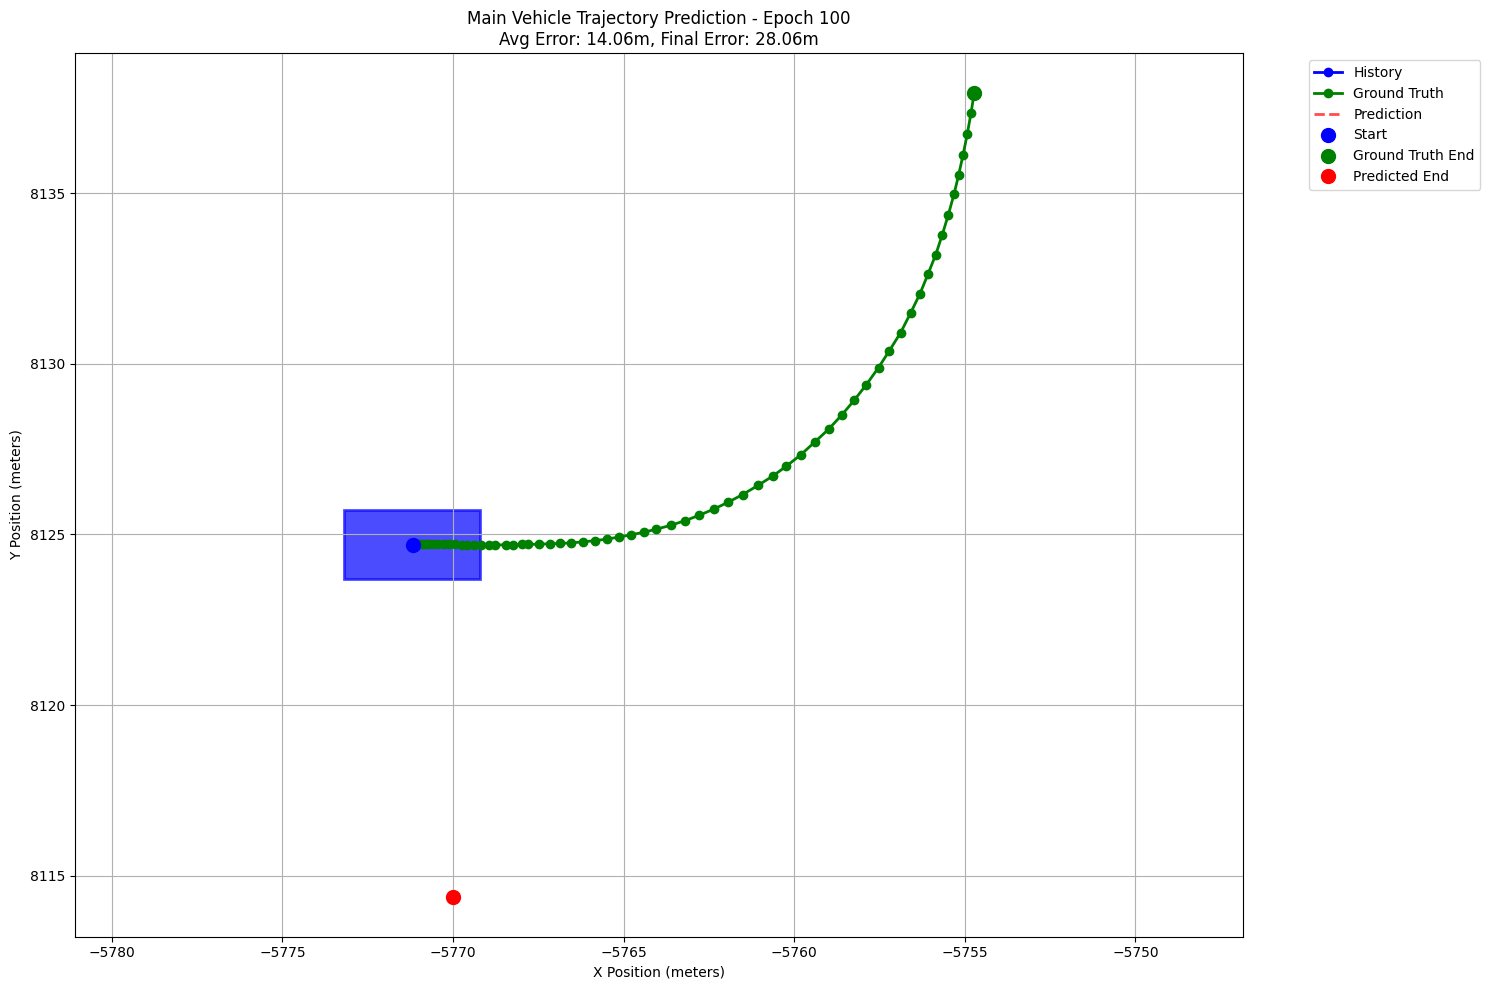


Epoch 150/200
epoch loss: 0.0008979639387689531
Average loss: 0.000898

Prediction Statistics:
Average prediction error: 392.40 meters
Final position error: 22.13 meters
Trajectory length - History: 11 steps, Future: 80 steps


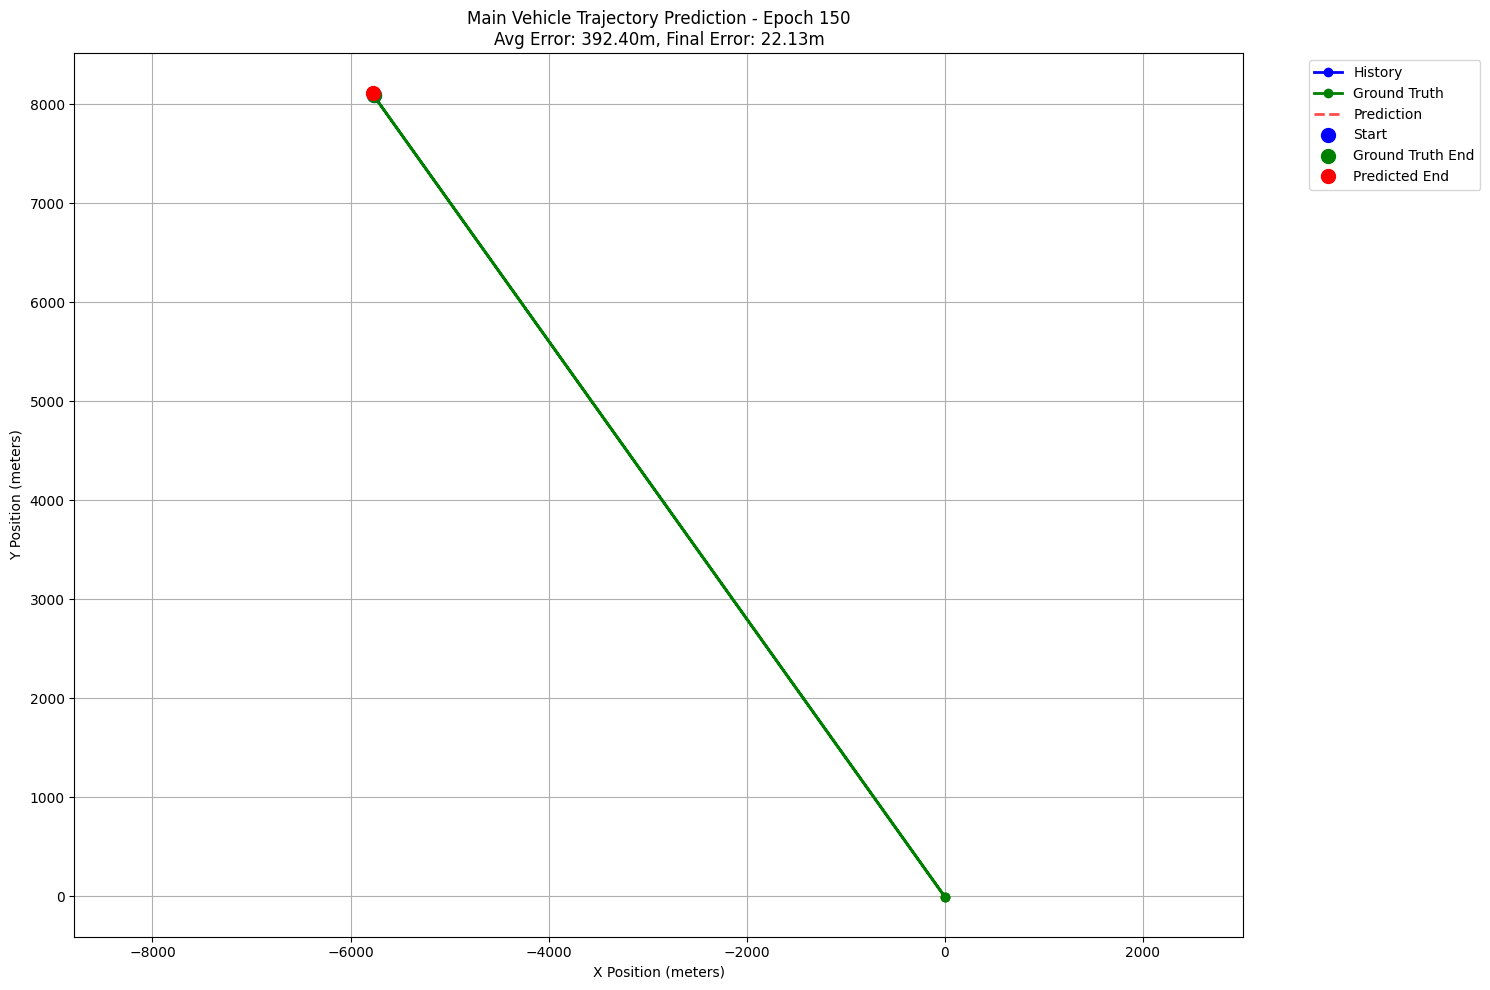


Epoch 200/200
epoch loss: 0.000577785714995116
Average loss: 0.000578

Prediction Statistics:
Average prediction error: 400.65 meters
Final position error: 30.45 meters
Trajectory length - History: 11 steps, Future: 80 steps


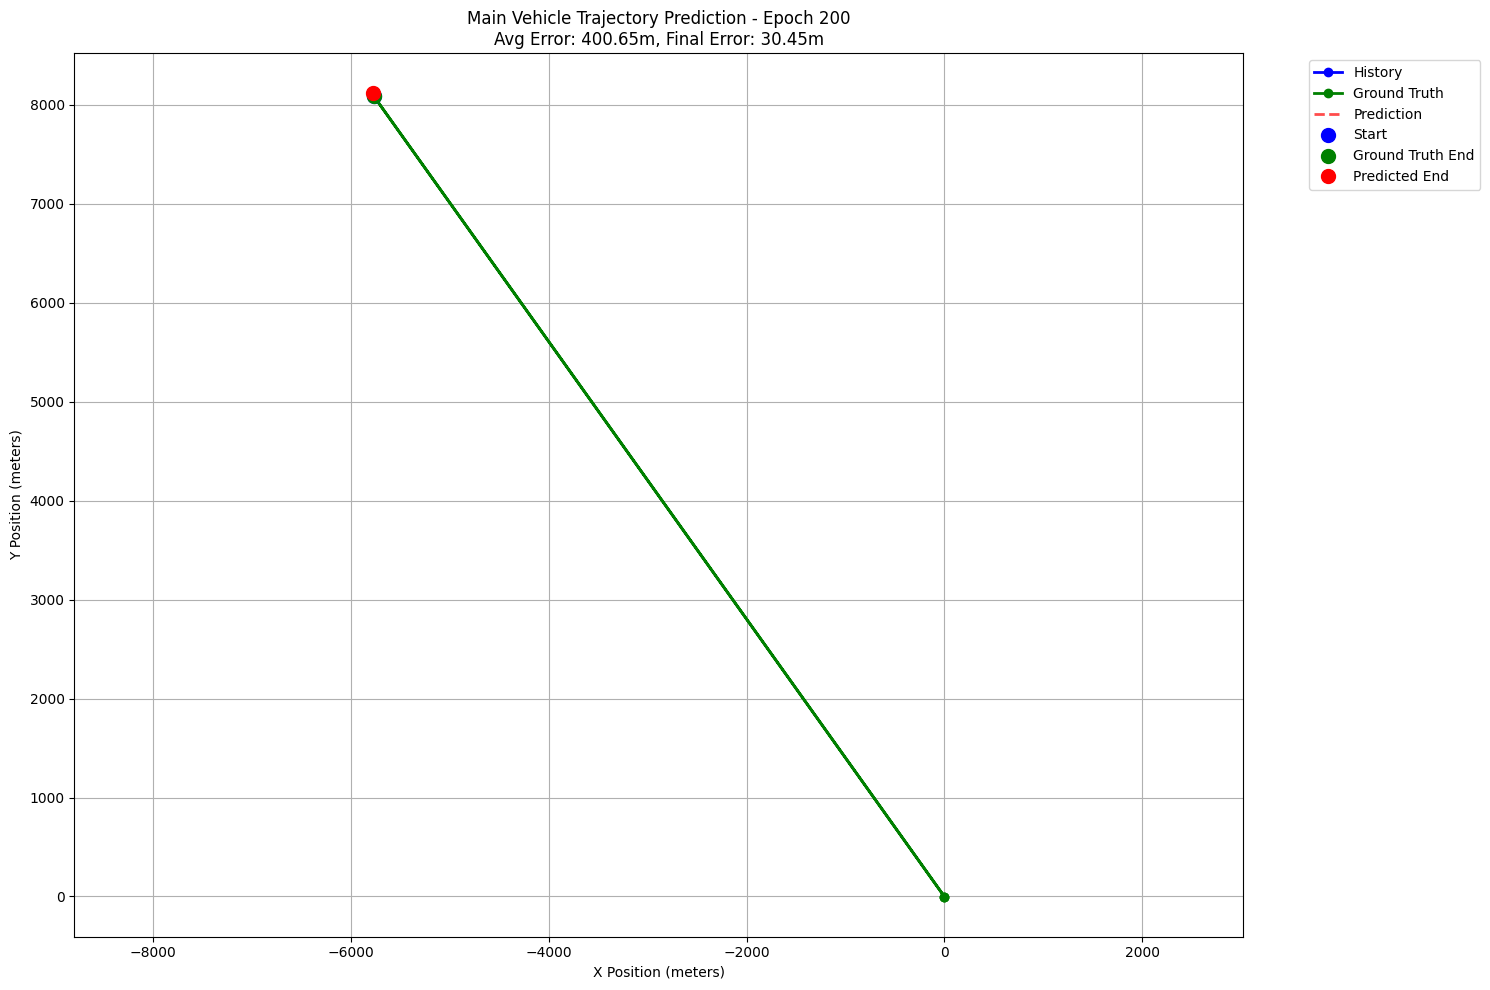


Training completed!
losses=[0.4148646295070648, 6.044300556182861, 1.0943578481674194, 0.04759477823972702, 0.2959814667701721, 0.17110179364681244, 0.08625543117523193, 0.042524755001068115, 0.019404323771595955, 0.014052683487534523, 0.011097338981926441, 0.012362142093479633, 0.010135652497410774, 0.008990909904241562, 0.008315760642290115, 0.008648260496556759, 0.008075029589235783, 0.008757452480494976, 0.009450527839362621, 0.009642690420150757, 0.009704561904072762, 0.0068912203423678875, 0.008108386769890785, 0.007290949579328299, 0.008030887693166733, 0.007816413417458534, 0.007963726297020912, 0.006608320400118828, 0.007963267154991627, 0.007136709522455931, 0.007727393880486488, 0.007335032802075148, 0.0071514444425702095, 0.007192314602434635, 0.005872723180800676, 0.006751577835530043, 0.005516970995813608, 0.005504908040165901, 0.0060135177336633205, 0.006352415308356285, 0.0060131121426820755, 0.0065535893663764, 0.006181464064866304, 0.0058054798282682896, 0.0063080759

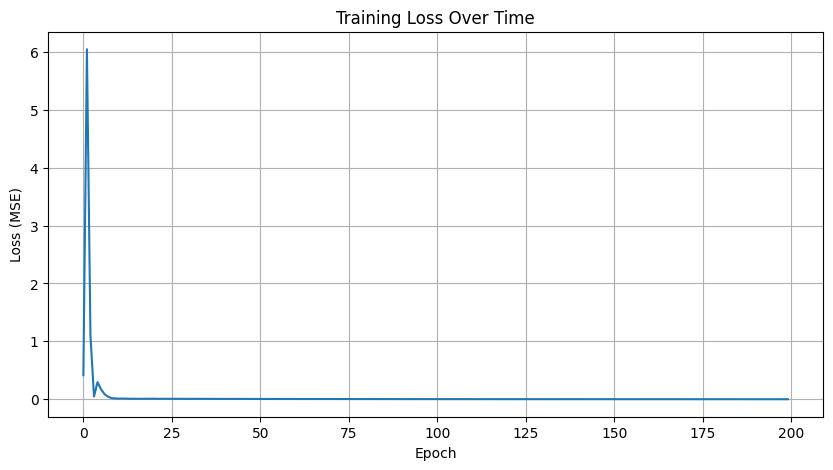

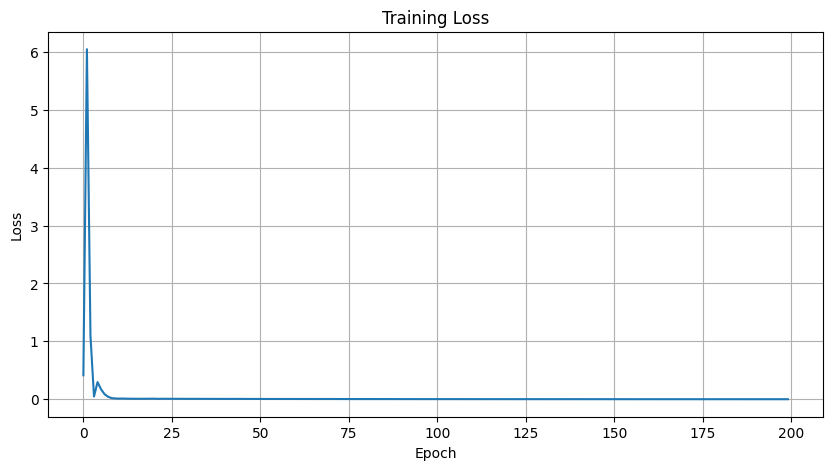

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from trajectory_dataset import TrajectoryDataset
from Transformer_NN_model import TrajectoryPredictorTransformer
   
class MainVehiclePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = TrajectoryPredictorTransformer()
    
    def forward(self, x):
        return self.base_model(x)
lr=0
epochs=0

def train_model(model, train_loader, epochs=epochs, lr=lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, ((hist, hist_valid), (fut, fut_valid)) in enumerate(train_loader):
            # Only take the first vehicle from each batch as main vehicle
            hist = hist[:, 0:1].to(device)  # Take first vehicle
            fut = fut[:, 0:1].to(device)
            hist_valid = hist_valid[:, 0:1].to(device)
            fut_valid = fut_valid[:, 0:1].to(device)
            
            optimizer.zero_grad()
            pred = model(hist)
            loss = criterion(pred * fut_valid.unsqueeze(-1), fut * fut_valid.unsqueeze(-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Visualize every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"epoch loss: {epoch_loss}")
            print(f"Average loss: {avg_loss:.6f}")
            
            
            model.eval()
            with torch.no_grad():
                # Get a sample trajectory
                hist, fut = next(iter(train_loader))[0][0][:1].to(device), next(iter(train_loader))[1][0][:1].to(device)
                pred = model(hist)
                
                # Visualize the prediction
                visualize_prediction(hist, fut, pred, epoch, train_loader.dataset)
    
    print("\nTraining completed!")
    print(f'losses={losses}')
    torch.save(model.state_dict(), 'trajectory_model.pth')

    # Plot final training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.show()

    return model, losses

def visualize_prediction(history, future, prediction, epoch, dataset):
    """
    Visualize the model's prediction with enhanced styling.
    Args:
        history: tensor of shape [1, 11, 2] - normalized historical trajectory
        future: tensor of shape [1, 80, 2] - normalized ground truth future trajectory
        prediction: tensor of shape [1, 80, 2] - normalized predicted future trajectory
        epoch: current training epoch
        dataset: dataset object for denormalization
    """
    # Denormalize all trajectories
    hist_denorm = dataset.denormalize(history.cpu())
    fut_denorm = dataset.denormalize(future.cpu())
    pred_denorm = dataset.denormalize(prediction.cpu())
    
    # Convert to numpy for plotting
    hist_denorm = hist_denorm.numpy()[0]  # [11, 2]
    fut_denorm = fut_denorm.numpy()[0]    # [80, 2]
    pred_denorm = pred_denorm.numpy()[0]   # [80, 2]
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot history trajectory
    plt.plot(hist_denorm[:, 0], hist_denorm[:, 1], 
            'o-', color='blue', alpha=1.0, linewidth=2,
            label='History')
    
    # Plot ground truth future trajectory
    plt.plot(fut_denorm[:, 0], fut_denorm[:, 1], 
            'o-', color='green', alpha=1.0, linewidth=2,
            label='Ground Truth')
    
    # Plot predicted future trajectory
    plt.plot(pred_denorm[:, 0], pred_denorm[:, 1], 
            '--', color='red', alpha=0.7, linewidth=2,
            label='Prediction')
    
    # Add vehicle rectangles at current position (last historical point)
    current_pos = hist_denorm[-1]
    # Assuming a standard vehicle size (you can adjust these)
    width, length = 2.0, 4.0

    # Vehicle rectangle at current position
    rect = Rectangle(
        (current_pos[0] - length/2, current_pos[1] - width/2),
        length, width,
        angle=0,  # We don't have yaw information here
        color='blue',
        alpha=0.7,
        linewidth=2
    )
    plt.gca().add_patch(rect)
    
    # Add markers for start and end points
    plt.plot(hist_denorm[0, 0], hist_denorm[0, 1], 'bo', markersize=10, label='Start')
    plt.plot(fut_denorm[-1, 0], fut_denorm[-1, 1], 'go', markersize=10, label='Ground Truth End')
    plt.plot(pred_denorm[-1, 0], pred_denorm[-1, 1], 'ro', markersize=10, label='Predicted End')
    
    # Calculate and display errors
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))
    
    plt.title(f'Main Vehicle Trajectory Prediction - Epoch {epoch + 1}\n'
             f'Avg Error: {error:.2f}m, Final Error: {final_error:.2f}m')
    plt.xlabel('X Position (meters)')
    plt.ylabel('Y Position (meters)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Print prediction statistics
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))

    print(f"\nPrediction Statistics:")
    print(f"Average prediction error: {error:.2f} meters")
    print(f"Final position error: {final_error:.2f} meters")
    print(f"Trajectory length - History: {len(hist_denorm)} steps, Future: {len(fut_denorm)} steps")
    
    plt.tight_layout()
    plt.show()
    
# The training function 

def main():
    # Load and prepare data
    dataset = TrajectoryDataset('processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000.npz')
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    # Create and train model LSTM
    model = MainVehiclePredictor()
    model, losses = train_model(model, train_loader, epochs=200, lr=0.009)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()